In [1]:
!pip install tf-keras-vis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 514.5 kB/s eta 0:00:00


In [2]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus
_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input

Tensorflow recognized 1 GPUs


In [3]:
# Загружаем модель
from tensorflow.keras.applications.vgg16 import VGG16 as Model
model = Model(weights='imagenet', include_top=True)
model.summary()

553467096/553467096 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

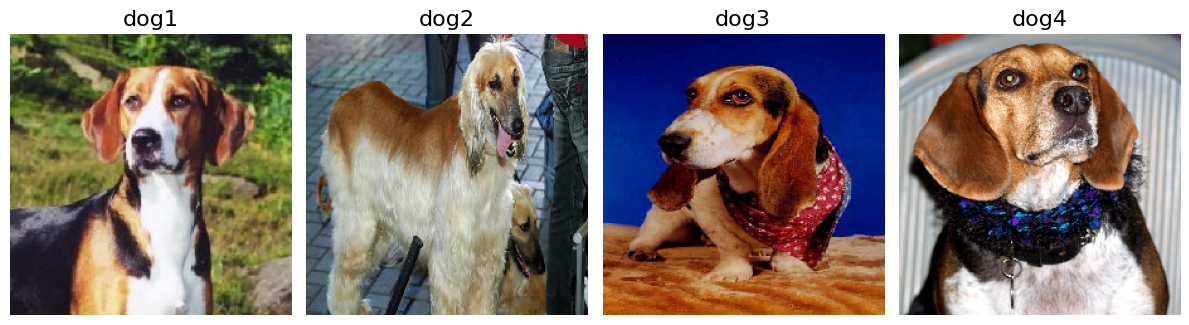

In [4]:
# Загружаем 4 изображения из ImageNet
image_titles = ['dog1', 'dog2', 'dog3', 'dog4']

img0 = load_img('dog1.jpg', target_size=(224, 224))
img1 = load_img('dog2.jpg', target_size=(224, 224))
img2 = load_img('dog3.jpg', target_size=(224, 224))
img3 = load_img('dog4.jpg', target_size=(224, 224))
images = np.asarray([np.array(img0), np.array(img1), np.array(img2), np.array(img3)])

X = preprocess_input(images)

f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [5]:
# Заменям на линейную функцию
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
replace2linear = ReplaceToLinear()
def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear
# Создаем функцию модификатора модели
from tf_keras_vis.utils.scores import CategoricalScore
score = CategoricalScore([41, 42, 62, 63])
def score_function(output):
    return (output[0][41], output[1][42], output[2][62], output[3][63])

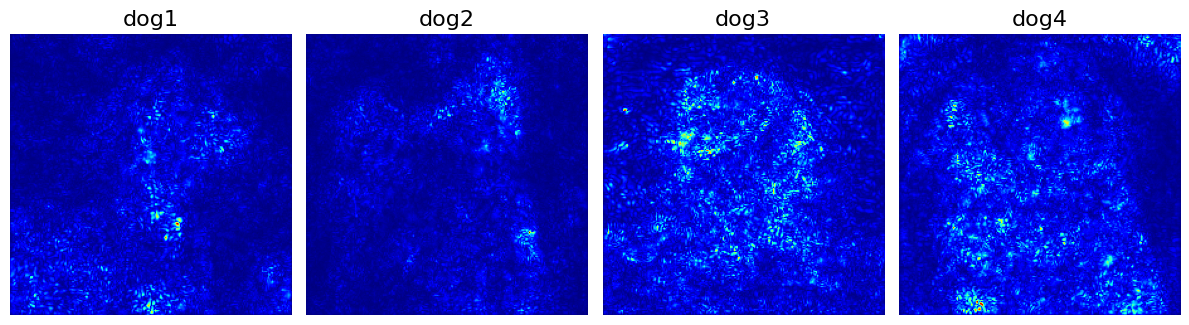

In [6]:
# Выведем сгенерирование карты внимания (vanilla)
from tf_keras_vis.saliency import Saliency
saliency = Saliency(model,model_modifier=replace2linear,clone=True)
saliency_map = saliency(score, X)

f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

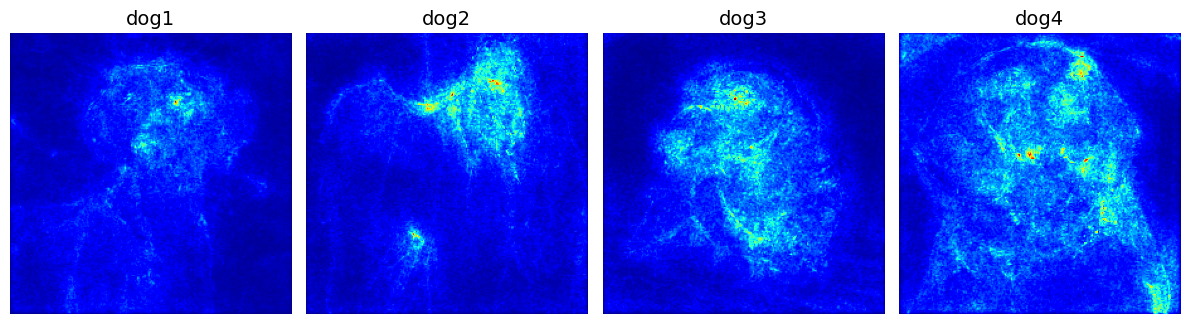

In [7]:
# Уменьшаем шум с помощбю SmoothGrad
saliency_map = saliency(score,X,smooth_samples=20,smooth_noise=0.20)
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.savefig('smoothgrad.png')
plt.show()

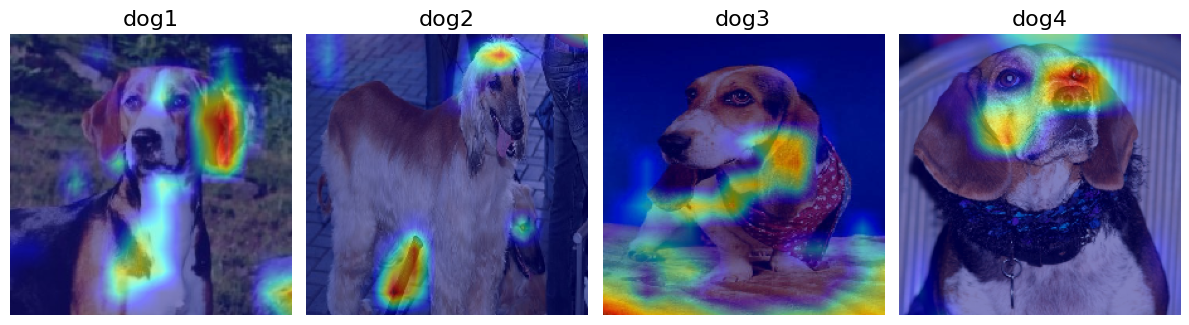

In [8]:
# Используем метод GrandCAM
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

gradcam = Gradcam(model,model_modifier=replace2linear,clone=True)
cam = gradcam(score,X,penultimate_layer=-1)
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :4] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()


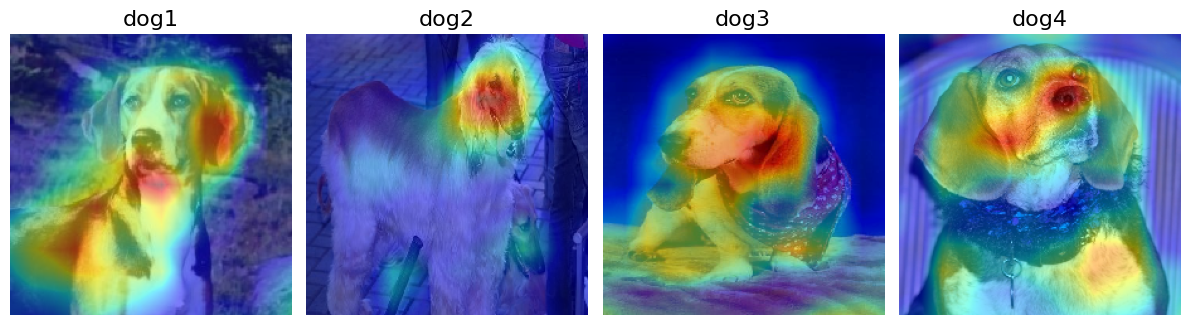

In [9]:
# Используем метод GrandCAM++
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus

gradcam = GradcamPlusPlus(model,model_modifier=replace2linear,clone=True)
cam = gradcam(score,X,penultimate_layer=-1)
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :4] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.savefig('gradcam_plus_plus.png')
plt.show()